In [1]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from nilearn.plotting import plot_glass_brain

## load DATA

In [2]:
single_subject = "/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_24_1_p.dat"
single_subject_brain = "/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp024/positive1/swracp024_p1.nii"
covariates_file = '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp024/positive1/covariates_test.csv'
cov = pd.read_csv(covariates_file, header=None)
#subject_brain = Brain_Data(single_subject_brain)
column_list =['condition', 'respout', 'RT', 'primeword', 'PrimeOnsetTime',
              'StimulusOnsetTime', 'TrialOffset', 'IAPS_ID', 'maxcatind', 'mincatind',
              'maxcatmean', 'mincatmean', 'maxmincat_power', 'AmusMean', 'AmusSD', 'AweMean',
              'AweSD','ExciMean','ExciSD','ContMean','ContSD','CongWord','CongNeutral','IncongWord','IncongNeutral']
subject_behavioural=pd.read_csv(single_subject,names=column_list,sep=' ')
subject_behavioural = subject_behavioural.drop([0,1])

In [3]:
# recode response
def responseRecode(responses):
    for i in range(0,len(responses)):
        current_response = responses[i]
        if current_response == 5:
            responses[i]=1
        else:
            responses[i] = current_response
    return responses
subject_behavioural.respout = responseRecode(subject_behavioural.respout.values)


## Create TR Space Matrix

In [4]:
def CreateRawDm(N_TR, TR_LENGTH,string_conditions, behavioural):
    
    N_CONDITIONS = 6#hard coded for now
    raw_dm = np.zeros((N_TR*TR_LENGTH*1000,N_CONDITIONS)) #convert from seconds to "millisecond tr space"
    for index, row in behavioural.iterrows():
        
        #for each row get onset time
        onset = float(row.StimulusOnsetTime)*1000
        offset = float(row.StimulusOnsetTime) * 1000 + 5 * 1000
        condition = int(row.condition)-1

        #amuse = 0
        #awe = 1
        #excited = 2
        emotion =3
        if(row.CongWord == string_conditions[0]):
            emotion = 3
        elif(row.CongWord==string_conditions[1]):
            emotion=4
        else:
            emotion = 5
         #create block design for design matrix   
        raw_dm[int(onset):int(offset), [condition, emotion]]=1
    return raw_dm

def CreateRawDmNoEmotion(N_TR, TR_LENGTH, behavioural):
    
    N_CONDITIONS = 3#hard coded for now
    raw_dm = np.zeros((N_TR*TR_LENGTH*1000,N_CONDITIONS)) #convert from seconds to "millisecond tr space"
    for index, row in behavioural.iterrows():
        
        #for each row get onset time
        onset = float(row.StimulusOnsetTime)*1000
        offset = float(row.StimulusOnsetTime) * 1000 + 5 * 1000
        condition = int(row.condition)-1 
        raw_dm[int(onset):int(offset), condition]=1
    return raw_dm

def CreateDMInTRSpace(N_TR,
                      TR_LENGTH,
                      string_conditions,
                      behavioural,
                     regressor_names,
                     run_num,
                     covariates=None):
    
    #raw_dm = CreateRawDm(N_TR, TR_LENGTH,string_conditions, behavioural)
    raw_dm = CreateRawDmNoEmotion(N_TR, TR_LENGTH, behavioural)
    dm = Design_Matrix(raw_dm, sampling_freq=1000, columns=regressor_names)
    dm = dm.convolve()
    
    dm_trspace = dm.iloc[::3000,:]#bad hard code but this is the TR length
    dm_trspace = dm_trspace.reset_index(drop=True)
    dm_trspace.sampling_freq= 1/TR_LENGTH
    
    cov = Design_Matrix(covariates, sampling_freq = 1/TR_LENGTH)
    cov['run_'+str(run_num)]=1
    cov = cov.fillna(0)
    cov_columns = cov.columns
    cov = cov.add_poly(1).add_dct_basis()
    
    return pd.concat([dm_trspace,cov], axis=1)
    




In [6]:
#data info
N_TR = 170
tr_length = 3
string_conditions=['amused','awe','excited']
regressor_names = ['congruent','incongruent','noprime']#,'amused','awe','excited']
fwhm = 6

#paths
first_level_folder = 'first_level_conditiononly_negative_1022519/'
part1_behavioural_data = "/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/"
motion_covariates = 'covariates/cp0{subject_num}/rp_acp0{subject_num}_n*.txt'
brains = "/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp0{subject_num}/negative*/swracp0{subject_num}_n*.nii"


column_list =['condition', 'respout', 'RT', 'primeword', 'PrimeOnsetTime',
              'StimulusOnsetTime', 'TrialOffset', 'IAPS_ID', 'maxcatind', 
              'mincatind','maxcatmean', 'mincatmean', 'maxmincat_power', 
              'AmusMean', 'AmusSD', 'AweMean','AweSD','ExciMean','ExciSD',
              'ContMean','ContSD','CongWord','CongNeutral','IncongWord',""
              'IncongNeutral']

behavioural=pd.read_csv(single_subject,names=column_list,sep=' ')

subject_list = np.linspace(1,30,30)
#for file in behavioural_files:
for i in subject_list: 
    
    all_runs = Design_Matrix(sampling_freq = 1/tr_length)
    
    subject_num_str = '0'+str(int(i)) if i <10 else str(int(i))
    positive_behaviourals = glob.glob(part1_behavioural_data + '*_' + str(int(i)) + '_*_n.dat')
    positive_covariates = glob.glob(motion_covariates.format(subject_num=subject_num_str))
    positive_brains_files = glob.glob(brains.format(subject_num=subject_num_str))
    
    print('loading brains for subject: \n\n',positive_brains_files)
    positive_brains = Brain_Data(positive_brains_files)
    
    print('creating dm for subject:',i)
    for i in range(len(positive_behaviourals)):
        print(positive_behaviourals[i])
        behavioural=pd.read_csv(positive_behaviourals[i],
                                names=column_list,
                                sep=' ')
        behavioural = behavioural.drop(behavioural.index[0:2])
        
        covariates = pd.read_csv(positive_covariates[i], header=None)
        dm_run = CreateDMInTRSpace(N_TR,
                                      tr_length,
                                      string_conditions,
                                      behavioural,
                                      regressor_names,
                                       i,
                                      covariates=covariates)
        
        dm_run.sampling_freq = 1/tr_length # why do we have to do this.... no one knows?
        all_runs = all_runs.append(dm_run,axis=0)
        
    all_runs = all_runs.fillna(0)    
    #regress and smooth
    positive_brains.X = all_runs
    stats = positive_brains.regress()
    smoothed = stats['beta'].smooth(fwhm=fwhm)
    
    #save data
    subject_folder = positive_covariates[0].split('/')[1]
    subject_folder_path = first_level_folder + subject_folder
    os.mkdir(subject_folder_path)
    stats['beta'].write(subject_folder_path + '/betas_unsmoothed.nii.gz')
    smoothed.write(subject_folder_path + '/betas_denoised_smoothed_preprocessed_fMRI_bold.nii.gz')
    all_runs.to_csv(subject_folder_path + '/design_matrix.csv')

    


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp001/negative1/swracp001_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp001/negative2/swracp001_n2.nii']
creating dm for subject: 1.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_1_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_1_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp002/negative1/swracp002_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp002/negative2/swracp002_n2.nii']
creating dm for subject: 2.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_2_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_2_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp003/negative1/swracp003_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp003/negative2/swracp003_n2.nii']
creating dm for subject: 3.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_3_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_3_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp004/negative1/swracp004_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp004/negative2/swracp004_n2.nii']
creating dm for subject: 4.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_4_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_4_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp005/negative1/swracp005_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp005/negative2/swracp005_n2.nii']
creating dm for subject: 5.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_5_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_5_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp006/negative1/swracp006_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp006/negative2/swracp006_n2.nii']
creating dm for subject: 6.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_6_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_6_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp007/negative1/swracp007_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp007/negative2/swracp007_n2.nii']
creating dm for subject: 7.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_7_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_7_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp008/negative1/swracp008_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp008/negative2/swracp008_n2.nii']
creating dm for subject: 8.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_8_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_8_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp009/negative1/swracp009_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp009/negative2/swracp009_n2.nii']
creating dm for subject: 9.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_9_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_9_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp010/negative1/swracp010_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp010/negative2/swracp010_n2.nii']
creating dm for subject: 10.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_10_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_10_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp011/negative1/swracp011_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp011/negative2/swracp011_n2.nii']
creating dm for subject: 11.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_11_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_11_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp012/negative1/swracp012_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp012/negative2/swracp012_n2.nii']
creating dm for subject: 12.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_12_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_12_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp013/negative1/swracp013_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp013/negative2/swracp013_n2.nii']
creating dm for subject: 13.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_13_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_13_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp014/negative1/swracp014_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp014/negative2/swracp014_n2.nii']
creating dm for subject: 14.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_14_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_14_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp015/negative1/swracp015_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp015/negative2/swracp015_n2.nii']
creating dm for subject: 15.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_15_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_15_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp016/negative1/swracp016_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp016/negative2/swracp016_n2.nii']
creating dm for subject: 16.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_16_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_16_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp017/negative1/swracp017_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp017/negative2/swracp017_n2.nii']
creating dm for subject: 17.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_17_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_17_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp018/negative1/swracp018_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp018/negative2/swracp018_n2.nii']
creating dm for subject: 18.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_18_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_18_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp019/negative1/swracp019_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp019/negative2/swracp019_n2.nii']
creating dm for subject: 19.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_19_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_19_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp020/negative1/swracp020_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp020/negative2/swracp020_n2.nii']
creating dm for subject: 20.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_20_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_20_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp021/negative1/swracp021_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp021/negative2/swracp021_n2.nii']
creating dm for subject: 21.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_21_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_21_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp022/negative1/swracp022_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp022/negative2/swracp022_n2.nii']
creating dm for subject: 22.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_22_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_22_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp023/negative1/swracp023_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp023/negative2/swracp023_n2.nii']
creating dm for subject: 23.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_23_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_23_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp024/negative1/swracp024_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp024/negative2/swracp024_n2.nii']
creating dm for subject: 24.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_24_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_24_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp025/negative1/swracp025_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp025/negative2/swracp025_n2.nii']
creating dm for subject: 25.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_25_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_25_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp026/negative1/swracp026_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp026/negative2/swracp026_n2.nii']
creating dm for subject: 26.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_26_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_26_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp027/negative1/swracp027_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp027/negative2/swracp027_n2.nii']
creating dm for subject: 27.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_27_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_27_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp028/negative1/swracp028_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp028/negative2/swracp028_n2.nii']
creating dm for subject: 28.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_28_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_28_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp029/negative1/swracp029_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp029/negative2/swracp029_n2.nii']
creating dm for subject: 29.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_29_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_29_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


loading brains for subject: 

 ['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp030/negative1/swracp030_n1.nii', '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp030/negative2/swracp030_n2.nii']
creating dm for subject: 30.0
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_30_1_n.dat
/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_30_2_n.dat


/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


In [23]:
all_runs.columns[[0,6,7]]

Index(['congruent_c0', 'incongruent_c0', 'noprime_c0'], dtype='object')

In [66]:
all_runs.to_csv(subject_folder_path + 'design_matrix.csv')

In [79]:
positive_brains

nltools.data.brain_data.Brain_Data(data=(340, 238955), Y=0, X=(340, 19), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])

In [82]:
glob.glob('first_level_emotcat_09282019/*/*.nii.gz')

['first_level_emotcat_09282019/cp001/betas_denoised_smoothed_preprocessed_fMRI_bold.nii.gz',
 'first_level_emotcat_09282019/cp002/betas_denoised_smoothed_preprocessed_fMRI_bold.nii.gz',
 'first_level_emotcat_09282019/cp003/betas_denoised_smoothed_preprocessed_fMRI_bold.nii.gz',
 'first_level_emotcat_09282019/cp004/betas_denoised_smoothed_preprocessed_fMRI_bold.nii.gz',
 'first_level_emotcat_09282019/cp005/betas_denoised_smoothed_preprocessed_fMRI_bold.nii.gz',
 'first_level_emotcat_09282019/cp006/betas_denoised_smoothed_preprocessed_fMRI_bold.nii.gz',
 'first_level_emotcat_09282019/cp007/betas_denoised_smoothed_preprocessed_fMRI_bold.nii.gz',
 'first_level_emotcat_09282019/cp008/betas_denoised_smoothed_preprocessed_fMRI_bold.nii.gz',
 'first_level_emotcat_09282019/cp009/betas_denoised_smoothed_preprocessed_fMRI_bold.nii.gz',
 'first_level_emotcat_09282019/cp010/betas_denoised_smoothed_preprocessed_fMRI_bold.nii.gz',
 'first_level_emotcat_09282019/cp011/betas_denoised_smoothed_preproces

In [111]:
data_dir = 'first_level_emotcat_09282019/'
file_list = glob.glob(os.path.join(os.getcwd(),data_dir, '*', 'betas_denoised_smoothed_preprocessed_fMRI_bold.nii.gz'))
df = pd.read_csv('/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/nipy/first_level_emotcat_09282019/cp001/design_matrix.csv')
for f in file_list:
    sub = os.path.dirname(f).split('/')[-1]
    print('doing sub', sub)
    dat = Brain_Data(f)
    for i in range(df.shape[1]-1):
        dat[i].write(os.path.join(data_dir, sub, f"{sub}_beta_{df.columns[i+1]}.nii.gz"))

doing sub cp001
doing sub cp002
doing sub cp003
doing sub cp004
doing sub cp005
doing sub cp006
doing sub cp007
doing sub cp008
doing sub cp009
doing sub cp010
doing sub cp011
doing sub cp012
doing sub cp013
doing sub cp014
doing sub cp015
doing sub cp016
doing sub cp017
doing sub cp018
doing sub cp019
doing sub cp020
doing sub cp021
doing sub cp022
doing sub cp023
doing sub cp024
doing sub cp025
doing sub cp026
doing sub cp027
doing sub cp028
doing sub cp029
doing sub cp030


In [5]:
dm = Design_Matrix(raw_dm, sampling_freq=1000, columns=['congruent',
                                                         'incongruent',
                                                         'noprime',
                                                         'amused',
                                                         'awe',
                                                         'excited'])

dm = dm.convolve()

AttributeError: 'function' object has no attribute 'data'

In [8]:
covariatesFile = '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp024/positive1/covariates_test.csv'
cov = pd.read_csv(covariatesFile, header=None)
cov = Design_Matrix(cov, sampling_freq = 1/3)

cov = cov.fillna(0)

# Retain a list of nuisance covariates (e.g. motion and spikes) which we'll also want to also keep separate for each run
cov_columns = cov.columns
cov = cov.add_poly(1).add_dct_basis()

In [11]:
dm_trspace = dm.iloc[::3000,:]
dm_trspace = dm_trspace.reset_index(drop=True)
dm_trspace.sampling_freq= 1/3
full = pd.concat([dm_trspace,cov], axis=1)

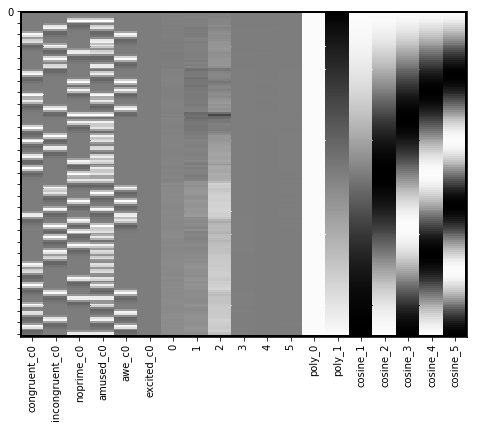

In [12]:
full.heatmap()

In [13]:
subject_brain.X = full
results = subject_brain.regress()

/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:983: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(np.linalg.pinv(np.dot(X.T, X))))[:, np.newaxis] * sigma[np.newaxis, :]
/Users/phoenix/anaconda3/lib/python3.6/site-packages/nltools/stats.py:992: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/phoenix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


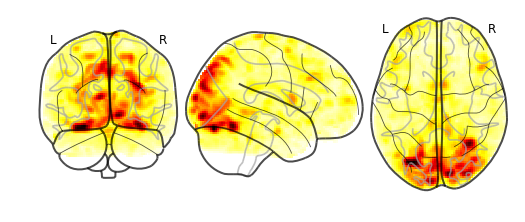

In [18]:
from nilearn.plotting import plot_glass_brain

plot_glass_brain(results['beta'][4].to_nifti())

In [125]:
subject_brain.X.columns

Index(['congruent_c0', 'incongruent_c0', 'noprime_c0', 'amused_c0', 'awe_c0',
       'excited_c0', '0', '1', '2', '3', '4', '5', 'poly_0', 'poly_1',
       'cosine_1', 'cosine_2', 'cosine_3', 'cosine_4', 'cosine_5'],
      dtype='object')

In [29]:
glob.glob("/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_24_*_p.dat")

['/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_24_1_p.dat',
 '/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_24_2_p.dat']

In [119]:
results.keys()

dict_keys(['beta', 't', 'p', 'sigma', 'residual'])

In [112]:
mask = Brain_Data(os.path.join(base_dir, 'resources', 'masks', 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)

f = mask.plot()

NameError: name 'base_dir' is not defined